In [23]:
%matplotlib inline
import pandas
import matplotlib.pyplot as plt
import datetime
import os
import glob

import numpy as np

In [15]:
def fill_missing_data(dataframe, granularity):
    # column names
    columns = dataframe.keys()
    
    dates = dataframe[columns[0]]
    prev = dates[0]
    time = []
    data = []

    for index in range(1, len(dates)-1):
        diff = dates[index] - prev
        prev = dates[index]


        if not diff.total_seconds() == granularity:
            total_steps = diff.total_seconds()
            new_data = [[dates[index] - datetime.timedelta(seconds=x),np.nan] for x in range(int(granularity), int(total_steps),int(granularity))]
            new_data.reverse()
            for item in new_data:
                time.append(item[0])
                data.append(item[1])

        time.append(prev)
        data.append(dataframe[columns[1]][index])
        
    columns = ['time', 'data']
    newDataframe = pandas.DataFrame(columns=columns)
    
    newDataframe.time = time
    newDataframe.data = data
    
    newDataframe.set_index('time')
    newDataframe.sort_values(by='time')
    newDataframe = newDataframe.interpolate()
    
    return newDataframe


def get_granularity(dataframe):
    # column names
    columns = dataframe.keys()
    
    dates = dataframe[columns[0]]
    prev = dates[0]
    diffs_counter=dict()

    for index in range(1, len(dates)-1):
        diff = dates[index] - prev
        prev = dates[index]

        if diff.total_seconds() not in diffs_counter.keys():
            diffs_counter[diff.total_seconds()]=1
        else:
            diffs_counter[diff.total_seconds()]+=1
    
    common_diff = list(diffs_counter)[(np.argmax(diffs_counter))]
    
    return common_diff
    

In [19]:
output_csv = 'filteredDataframe.csv' 

# loading dataset
dataframe = pandas.read_csv('../fwddadosdma2/00010391_GLE_CABIL_2P1F_FLOW.csv', engine='python', header=0)
dataframe.head()

,dateTime,data
0,2018-01-01 00:15:00,3.944
1,2018-01-01 00:30:00,3.722
2,2018-01-01 00:45:00,4.194
3,2018-01-01 01:00:00,4.000
4,2018-01-01 01:15:00,3.250


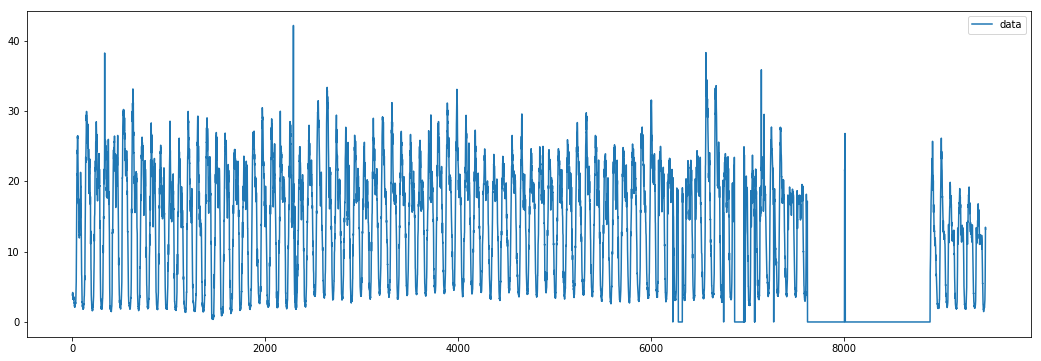

In [20]:
dataframe.plot(figsize=(18,6))

In [21]:
# column names
columns = dataframe.keys()

# converting to datetime
dataframe[columns[0]]= pandas.to_datetime(dataframe[columns[0]])

granularity     = get_granularity(dataframe)
preprocessed_df = fill_missing_data(dataframe, granularity)

# saving the new dataset
preprocessed_df.to_csv(output_csv)

# Extendendo para todas as series

In [27]:
basefolder = '../dados/'
data = glob.glob(basefolder + '*.csv')

for filename in data:
    print("processando : ", filename)
    outputname = os.path.basename(filename) + '_filtered.csv'
    
    # loading dataset
    dataframe = pandas.read_csv(filename, engine='python', header=0)
    
    # column names
    columns = dataframe.keys()

    # converting to datetime
    dataframe[columns[0]] = pandas.to_datetime(dataframe[columns[0]])

    granularity     = get_granularity(dataframe)
    preprocessed_df = fill_missing_data(dataframe, granularity)

    # salvando o resultado em um novo csv
    preprocessed_df.to_csv(outputname)
    

processando :  ../dados/00010391_GLE_CABIL_2P1F_FLOW.csv
processando :  ../dados/101981_GLE_CABIL_1P0F_EXP_PRES_C3.csv
processando :  ../dados/102048_GLE_CABIL_1P0F_EXP_PRES_C3.csv
processando :  ../dados/41222_DNK_CABIL_CTRLB_FLOW (1).csv
processando :  ../dados/41222_DNK_CABIL_CTRLB_FLOW.csv
processando :  ../dados/7397_DNK_CABIL_PCRIP_PRES_C3 (1).csv
processando :  ../dados/7397_DNK_CABIL_PCRIP_PRES_C3.csv
processando :  ../dados/dma1.1_flow.csv
processando :  ../dados/dma1.1_pressure.csv
processando :  ../dados/dma1_flow.csv
processando :  ../dados/SCADA001.EVAP_HUMERE_LVINS_MDC02.F_CV copy.csv
processando :  ../dados/SCADA001.EVAP_HUMERE_LVINS_MDC02.F_CV.csv
processando :  ../dados/SCADA001.EVAP_HUMERE_LVINS_MDC03.F_CV copy.csv
processando :  ../dados/SCADA001.EVAP_HUMERE_LVINS_MDC03.F_CV.csv
processando :  ../dados/SCADA001.EVAP_HUMERE_LVINS_MDC05.F_CV.csv
